In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['flare0_informed',]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net_path'][round] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                         +round+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')
        priors[name]['net'][round] = network.NetworkCorner(
            nbins=priors[name]['A'].nbins,
            marginals=priors[name]['POI_indices'],
            param_names=priors[name]['A'].param_names,
            **hyperparams_point,
        )
        priors[name]['net'][round].load_state_dict(torch.load(priors[name]['net_path'][round]))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')

In [6]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [7]:
def references1D_1(samples):
    return np.ones((len(samples),1))*0.2

def references1D_2(samples):
    return np.ones((len(samples),1))*0.5

def references1D_3(samples):
    return np.ones((len(samples),1))*0.8


def references1D_4(samples):
    mins = np.min(samples['data'], axis=0)
    maxes = np.max(samples['data'], axis=0)
    refs = np.sum((samples['data'] - mins)/(maxes-mins),axis=-1)
    max_ref = np.max(refs)
    min_ref = np.min(refs)
    return ((refs-min_ref)/(max_ref-min_ref))[:,np.newaxis]

def references1D_5(samples):
    mins = np.min(samples['data'], axis=0)
    maxes = np.max(samples['data'], axis=0)
    refs = np.sum(np.log(samples['data'] - mins+0.0001)/(maxes-mins),axis=-1)
    max_ref = np.max(refs)
    min_ref = np.min(refs)
    return ((refs-min_ref)/(max_ref-min_ref))[:,np.newaxis]

def references1D_6(samples):
    refs = np.exp(1./(references1D_4(samples)+1))
    max_ref = np.max(refs)
    min_ref = np.min(refs)
    return ((refs-min_ref)/(max_ref-min_ref))
    
###########################################################################################

def references2D_1(samples):
    return np.ones((len(samples),2))*0.2

def references2D_2(samples):
    return np.ones((len(samples),2))*0.5

def references2D_3(samples):
    return np.ones((len(samples),2))*0.8


def references2D_4(samples):
    half1 = int(len(samples['data'][0])/2)
    half2 = len(samples['data'][0])-half1
    mins1 = np.min(samples['data'][:,:half1], axis=0)
    maxes1 = np.max(samples['data'][:,:half1], axis=0)
    mins2 = np.min(samples['data'][:,half1:], axis=0)
    maxes2 = np.max(samples['data'][:,half1:], axis=0) 
    refs1 = np.sum((samples['data'][:,:half1] - mins1)/half1*(maxes1-mins1),axis=-1)
    refs2 = np.sum((samples['data'][:,half1:] - mins2)/half2*(maxes2-mins2),axis=-1)
    max_ref1 = np.max(refs1)
    min_ref1 = np.min(refs1)
    max_ref2 = np.max(refs2)
    min_ref2 = np.min(refs2)
    
    return np.array( [((refs1-min_ref1)/(max_ref1-min_ref1)),((refs2-min_ref2)/(max_ref2-min_ref2))] ).transpose()

def references2D_5(samples):
    half1 = int(len(samples['data'][0])/2)
    half2 = len(samples['data'][0])-half1
    mins1 = np.min(samples['data'][:,:half1], axis=0)
    maxes1 = np.max(samples['data'][:,:half1], axis=0)
    mins2 = np.min(samples['data'][:,half1:], axis=0)
    maxes2 = np.max(samples['data'][:,half1:], axis=0) 
    refs1 = np.sum(np.log(samples['data'][:,:half1]-mins1+0.0001)/(maxes1-mins1),axis=-1)
    refs2 = np.sum(np.log(samples['data'][:,half1:]-mins2+0.0001)/(maxes2-mins2),axis=-1)
    max_ref1 = np.max(refs1)
    min_ref1 = np.min(refs1)
    max_ref2 = np.max(refs2)
    min_ref2 = np.min(refs2)
    
    return np.array( [((refs1-min_ref1)/(max_ref1-min_ref1)),((refs2-min_ref2)/(max_ref2-min_ref2))] ).transpose()

def references2D_6(samples):
    refs = np.exp(1./(references2D_4(samples)+1))
    max_ref = np.max(refs)
    min_ref = np.min(refs)
    return ((refs-min_ref)/(max_ref-min_ref))


In [8]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
from DRP_test import get_drp_coverage, draw_DRP_samples_fast

In [9]:
name = names[0]
n_samps = 1000
n_prior_samps=10_000
samples = priors[name]['samples'][-n_samps:]
prior_samples = priors[name]['samples_prior'][:n_prior_samps]
which_truncation = priors[name]['which_truncation']
which_grid_point = priors[name]['which_grid_point']
POIs = priors[name]['POI_indices']
A = priors[name]['A']
bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])

draws1d = {}
draws2d = {}
weights1d = {}
weights2d = {}
for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    draws1d[round],draws2d[round],weights1d[round],weights2d[round] = draw_DRP_samples_fast(
        priors[name]['net'][round],
        trainer,
        samples,
        prior_samples,
    )

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [10]:
references_1d = [
    references1D_6(samples),
]

references_2d = [
    references2D_6(samples),
]

In [11]:
round_colors = ['r','y','g','b']

In [12]:
which_truncation = 3

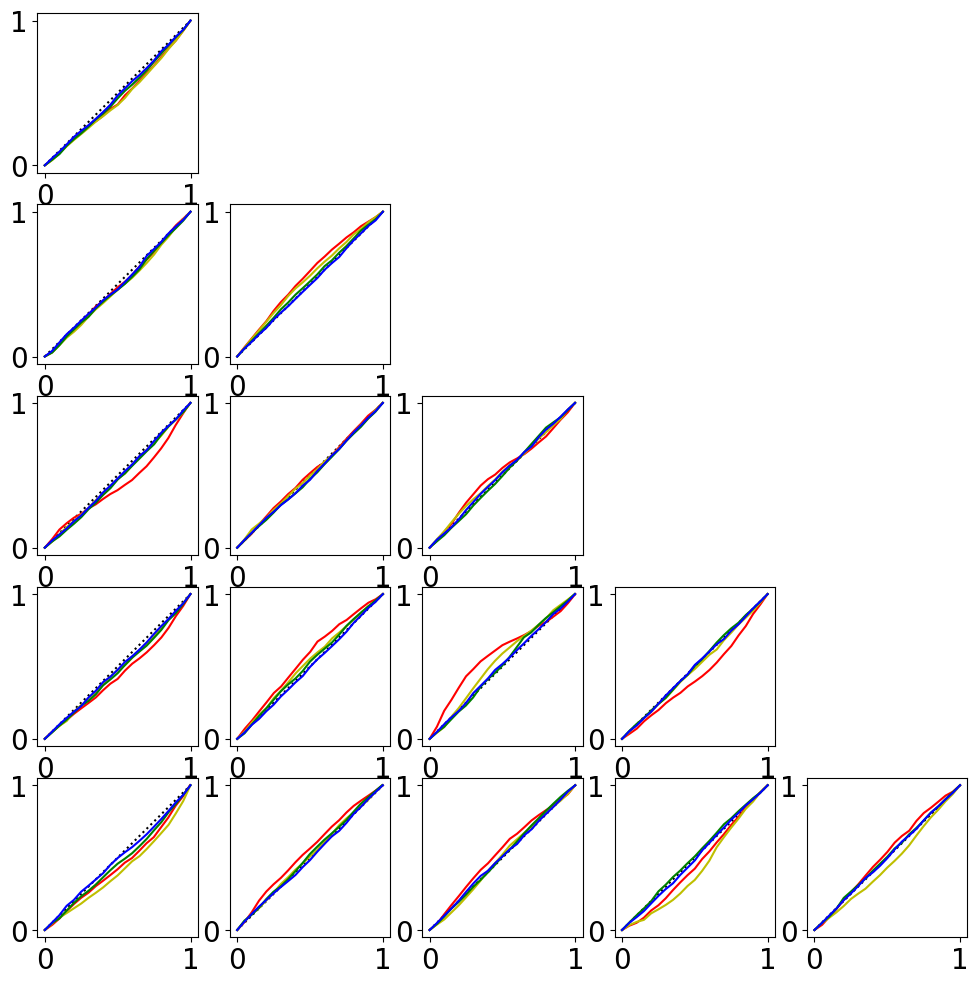

In [14]:
ecp = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
alpha = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
f = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }

for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    for ref_i in range(len(references_1d)):
        for i, key in enumerate(draws1d[round].keys()):
        
            ecp[round][0][ref_i][key], alpha[round][0][ref_i][key], f[round][0][ref_i][key], _ = get_drp_coverage(
                draws1d[round][key],
                samples['params'][:,[POIs[i]]],
                weights = weights1d[round][key],
                theta_names=A.param_names[POIs[i]],
                bounds = np.array(bounds)[[POIs[i]]],
                references = references_1d[ref_i],
            )

rows = len(POIs)

for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    for ref_i in range(len(references_2d)): 
        row = 0
        column = 0
        for i, key in enumerate(draws2d[round].keys()):
            row+=1
            if row >= rows:
                column+=1
                row = 1+column    
            ecp[round][1][ref_i][key], alpha[round][1][ref_i][key], f[round][1][ref_i][key], _ = get_drp_coverage(
                draws2d[round][key],
                samples['params'][:,[column,row]],
                weights = weights2d[round][key],
                theta_names=np.array(A.param_names)[[column,row]],
                bounds = np.array(bounds)[[column,row]],
                references = references_2d[ref_i],
            )


fig_DRP = plt.figure(figsize = (12, 12))


for i, key in enumerate(draws1d['round_0'].keys()):
    fig_DRP.add_subplot(rows, rows, i+1+i*rows)
    plt.plot([0,1],[0,1], 'k:')
    # plt.xlabel("Credibility level (alpha)")
    # plt.ylabel("ECP")
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_1d)):
            ecp_ex = np.zeros(len(ecp[round][0][ref_i][key])+1)
            alpha_ex = np.zeros(len(alpha[round][0][ref_i][key])+1)
            ecp_ex[1:] = ecp[round][0][ref_i][key]
            alpha_ex[1:] = alpha[round][0][ref_i][key]
            plt.plot(alpha_ex, ecp_ex, round_colors[rnd])
        

row = 0
column = 0
for i, key in enumerate(draws2d['round_0'].keys()):
    row+=1
    if row >= rows:
        column+=1
        row = 1+column 
    fig_DRP.add_subplot(rows, rows, rows*row+column+1)
    plt.plot([0,1],[0,1], 'k:')
    # plt.xlabel("Credibility level")
    # plt.ylabel("ECP")
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_2d)):
            ecp_ex = np.zeros(len(ecp[round][1][ref_i][key])+1)
            alpha_ex = np.zeros(len(alpha[round][1][ref_i][key])+1)
            ecp_ex[1:] = ecp[round][1][ref_i][key]
            alpha_ex[1:] = alpha[round][1][ref_i][key]
            plt.plot(alpha_ex, ecp_ex, round_colors[rnd])
